In [1]:
import pymongo
import pandas as pd
import json
import knowhere_db as kdb

In [2]:
reader = kdb.Reader(db_name='knowhere')
data = reader.get_dataframe('iphone_test')
data.head()

,_id,data,sensor,timestamp,user_id
0,58cb1893ea2bfa0900a3ca68,"{u'Latitude': u'40.7530392755199', u'Vertical ...",GPS,2017-03-08 10:38:48,58c5b91d71a9e82f33ad1668
1,58cb1893ea2bfa0900a3ca69,"{u'y': u'0.0504199266433716', u'x': u'-0.00513...",Acceleration,2017-03-08 10:38:49,58c5b91d71a9e82f33ad1668
2,58cb1893ea2bfa0900a3ca6a,"{u'Pressure': u'101.2276611328125', u'Relative...",Altimeter (Barometer),2017-03-08 10:38:49,58c5b91d71a9e82f33ad1668
3,58cb1893ea2bfa0900a3ca6b,"{u'Yaw': u'-0.422258717009882', u'Quarternion ...",Attitude,2017-03-08 10:38:49,58c5b91d71a9e82f33ad1668
4,58cb1893ea2bfa0900a3ca6c,"{u'State': u'Discharging', u'Level': u'0.55'}",Battery,2017-03-08 10:38:49,58c5b91d71a9e82f33ad1668


### Plotting Functions

In [11]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn
from datetime import datetime

In [12]:
data.user_id.unique()

array([ObjectId('58c5b91d71a9e82f33ad1668'),
       ObjectId('58c5b91d71a9e82f33ad1669')], dtype=object)

In [13]:
def get_daily_data(day, user_id = kdb.ObjectId('58c5b91d71a9e82f33ad1669'), sensor = "GPS", collection = "iphone_test"):
    to_plot = reader.get_dataframe_pivoted(collection = collection, user_id = user_id, sensor = sensor)
    to_plot = to_plot.ix[day]
    to_plot = to_plot.astype(float)
    #plt.plot(to_plot['GPS (Latitude)'], to_plot['GPS (Longitude)'], zorder = 2)
    plt.scatter(to_plot['GPS (Latitude)'], to_plot['GPS (Longitude)'], zorder = 1, c = to_plot.index)
    plt.xlabel("Latitude")
    plt.ylabel("Longitude")
    plt.title("Location Data for %s" % (day))
    

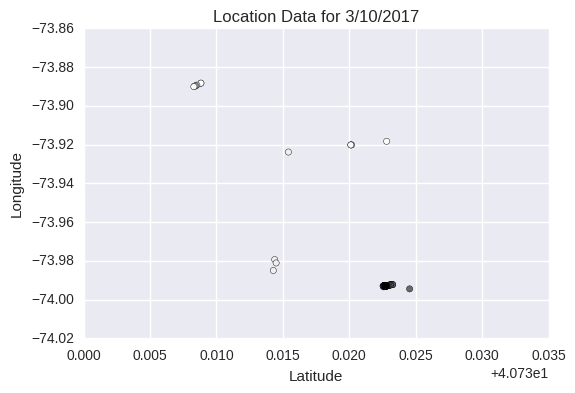

In [14]:
get_daily_data('3/10/2017')

In [29]:
t1 = reader.get_dataframe_pivoted(collection = 'iphone_test', sensor = "Acceleration")

knowhere_db.py:74: Warning: Excluding user_id from filter can cause errors during pivot
  warnings.warn('Excluding user_id from filter can cause errors during pivot', Warning)


In [30]:
t1 = t1.astype(float)

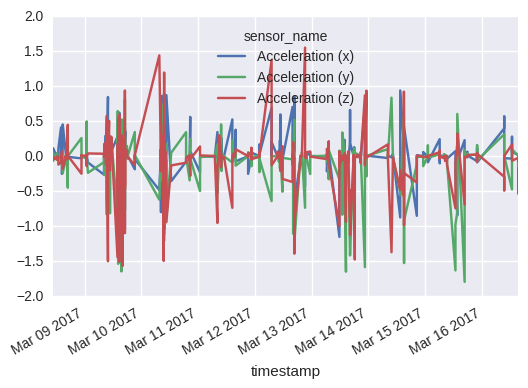

In [31]:
t1.plot()

In [32]:
from math import sqrt

accel_mag = []
for row in range(len(t1)):
    accel_mag.append(sqrt(t1.iloc[row, 0]**2 + t1.iloc[row, 1]**2 + t1.iloc[row, 2]**2))
    
t1['accel_mag'] = accel_mag

In [33]:
#check acceleration levels are various percentiles, just to see what's there
accel_thresholds = []

for quan in np.linspace(0, 1.0, 9):
    accel_thresholds.append((quan, t1['accel_mag'].quantile(q=quan)))
    
accel_thresholds

[(0.0, 0.0),
 (0.125, 0.005405385705153482),
 (0.25, 0.006505375143762363),
 (0.375, 0.007741483913662784),
 (0.5, 0.009681526024984075),
 (0.625, 0.013445551433988626),
 (0.75, 0.026667841227595288),
 (0.875, 0.08279523421398678),
 (1.0, 1.939071038049297)]

In [34]:
#set a threshold based on 1 day of Emil's data, ideally we'll set this based off of all user data
activity_threshold = 0.051845671879112265

In [35]:
def check_single_active(accel_mag, activity_threshold = 0.051845671879112265):
    if accel_mag >= activity_threshold:
        return 1
    else:
        return 0
    return 0


In [36]:
def check_active(mag_list):
    mag_list = list(mag_list)
    activity_raw = 0
    for active in mag_list:
        activity_raw += check_single_active(active)
    return float(activity_raw) / len(t1['accel_mag'])

In [37]:
check_active(t1['accel_mag'])

0.16596736596736597

### Distance Traveled

In [85]:
#Haversine Function, jacked from stackoverflow

def haversine(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points
    on the earth (specified in decimal degrees, AKA Latitude / Longitude)

    All args must be of equal length.    

    """
    
    from math import radians, cos, sin, asin, sqrt

    # convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])

    #haversine formula
    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2

    c = 2 * np.arcsin(np.sqrt(a))
    miles = 3956 * c # Radius of earth in miles. Use 6370 for kilometers
    return miles

#df['dist'] = haversine_np(df.LONG.shift(), df.LAT.shift(), df.ix[1:, 'LONG'], df.ix[1:, 'LAT'])

In [86]:
t2 = reader.get_dataframe_pivoted(collection = 'iphone_test', sensor = "GPS", username = 'emil')

In [87]:
t2 = t2.astype(float)

In [151]:
def daily_distance_traveled(day, username):
    #Get day after day passed into function so that DB call works
    import pandas.tseries.offsets as pdo
    next_day = pd.to_datetime(day) + pdo.Day()
    
    #make DB query to get GPS data for specified day 
    day_dist = reader.get_dataframe_pivoted(collection = 'iphone_test', sensor = "GPS", username = username,
                                min_date = str(day), max_date = str(next_day))
    day_dist = day_dist.astype(float)
    
    dist_traveled = haversine(day_dist['GPS (Longitude)'].shift(), day_dist['GPS (Latitude)'].shift(), 
          day_dist.ix[1:, 'GPS (Longitude)'], day_dist.ix[1:, 'GPS (Latitude)'])
    return dist_traveled

In [152]:
daily_distance_traveled('03/10/2017', 'glen').sum()

7.349103022157515